Para cargar los datos en memria voy a usar funciones básicas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle

#importamos librerias

import sys
sys.path.append('../src/CTA-data-analisis-library/')
import os 
import subprocess
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf 
import psutil
import re
import random
import shutil
import pickle
from numba import cuda
import gc

#propias
import unzipdata_and_first_treatments as manipulate
import loaddata4use
import model_creation_functions as models

In [2]:
aux1=[]
aux3=[]
for i in range(1,6):
    with open(f"../modelos/performances/007_history_modelo_filtro_0_en_boostrap_stage_{i}_energy.pickle","rb") as fil:
        hist=pickle.load(fil)
        aux1.append(hist["loss"])
        aux3.append(hist["val_loss"])

In [3]:
aux2=[j for i in aux1 for j in i]
aux4=[j for i in aux3 for j in i]



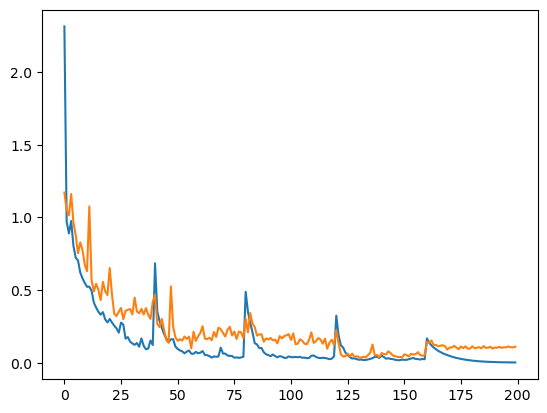

In [4]:
plt.plot(aux2)
plt.plot(aux4)


## Carga de datos de test

In [5]:
def runs_disponibles(npy_dir,elements):
    lista=[]
    for i in elements:
        npy_element_dir=os.path.join(npy_dir,"npy_"+i)
        runs=[int(re.search("run_([0-9]{3})_0\.npy",i).group(1)) for i in os.listdir(npy_element_dir) if re.search("run_([0-9]{3})_0\.npy",i)]
        lista.append(runs)
    return lista


def new_create_main_list_runs(number_runs_per_element,posibles_runs):
    #esto es aleatorio por defecto, porque es lo unico que necesito por ahora    
    final=[]
    for ind,lista_runs_element in enumerate(posibles_runs):
        final.append(random.sample(lista_runs_element,number_runs_per_element[ind]))
    return final

#tenemos que hacer un ligero cambio porque se estan cargando con los ejes cambiados
def cambiar_ejes_lista(lista):
    for i,j in enumerate(lista):
        lista[i]=np.swapaxes(j,1,2)
    return lista


In [6]:
#enviroment variables
npy_final_dir="../datos/elementos_npy_test"
base_dir_elementos="../datos/elementos"
elements=['gamma', 'electron']

In [7]:
chose_runs=runs_disponibles(npy_final_dir,elements)


In [9]:
list_runs=new_create_main_list_runs([32,80],chose_runs)#new_create_main_list_runs([2,6,6,6,6,6,6],chose_runs)

x_train_list,x_test_list,y_train_list,y_test_list,element_shapes=loaddata4use.load_dataset_energy(npy_final_dir,base_dir_elementos,elementos=['gamma', 'electron'],
                                                        main_list_runs=list_runs,telescopios=[1,2,3,4],test_size=0,return_shapes=True,
                                                        same_quant="all",verbose=True,fill=True,lower_energy_bound=1,
                                                        upper_energy_bound=10)
x_train_list=cambiar_ejes_lista(x_train_list)
#x_test_list=cambiar_ejes_lista(x_test_list)


Load of names and common events
_______________
Runs:  [47, 8, 30, 30, 26, 32, 16, 16, 8, 16, 4, 9, 9, 19, 8, 4, 30, 26, 8, 9, 19, 46, 32, 9, 47, 26, 19, 46, 26, 47, 4, 19]
Element:  gamma  , Run:  47  Shape of common events (common events, energies):  (4, 1087) (4, 1087)
Element:  gamma  , Run:  8  Shape of common events (common events, energies):  (4, 1066) (4, 1066)
Element:  gamma  , Run:  30  Shape of common events (common events, energies):  (4, 1111) (4, 1111)
Element:  gamma  , Run:  30  Shape of common events (common events, energies):  (4, 1111) (4, 1111)
Element:  gamma  , Run:  26  Shape of common events (common events, energies):  (4, 1113) (4, 1113)
Element:  gamma  , Run:  32  Shape of common events (common events, energies):  (4, 1147) (4, 1147)
Element:  gamma  , Run:  16  Shape of common events (common events, energies):  (4, 1134) (4, 1134)
Element:  gamma  , Run:  16  Shape of common events (common events, energies):  (4, 1134) (4, 1134)
Element:  gamma  , Run:  8  

In [10]:
element_shapes

[4124, 4455]

(array([2730., 1604., 1016.,  795.,  682.,  602.,  334.,  299.,  247.,
         270.]),
 array([1.001  , 1.40071, 1.80042, 2.20013, 2.59984, 2.99955, 3.39926,
        3.79897, 4.19868, 4.59839, 4.9981 ]),
 <BarContainer object of 10 artists>)

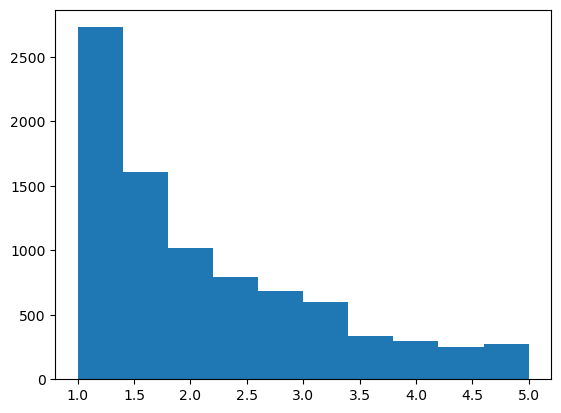

In [11]:
plt.hist(y_train_list)

In [12]:
#cargamos el ultimo modelo de los dos filtros:
modelos=[tf.keras.models.load_model(name) for name in glob("../modelos/007_modelo_filtro_*_en_boostrap_stage_10_energy.h5")]


2023-02-15 15:11:24.042063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:11:24.102421: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
y_pred_all=[]
total_len=x_train_list[1].shape[0]
n=400
cicles=int(np.ceil(total_len/n))
for i in range(cicles):
    print("Ciclo",i)
    if (n*i+n)>=total_len:
        final=total_len
    else:
        final=n*i+n

    x_aux=[ x[(n*i):final,:,:,:] for x in x_train_list]
    print("Shape",x_aux[0].shape)
    y_pred=[model(x_aux).numpy() for model in modelos]
    if i==0:
        y_pred_all=y_pred
    else:
        for j in range(len(y_pred_all)):
            y_pred_all[j]=np.concatenate([y_pred_all[j],y_pred[j]],axis=0)

Ciclo 0
Shape (400, 55, 93, 1)
Ciclo 1
Shape (400, 55, 93, 1)
Ciclo 2
Shape (400, 55, 93, 1)
Ciclo 3
Shape (400, 55, 93, 1)


In [ ]:
print( len(y_pred_all), y_pred_all[0].shape)

3 (5480, 1)


In [ ]:
# Polynomial Regression
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results["y_pred"]=yhat
    results['determination'] = ssreg / sstot

    return results,p

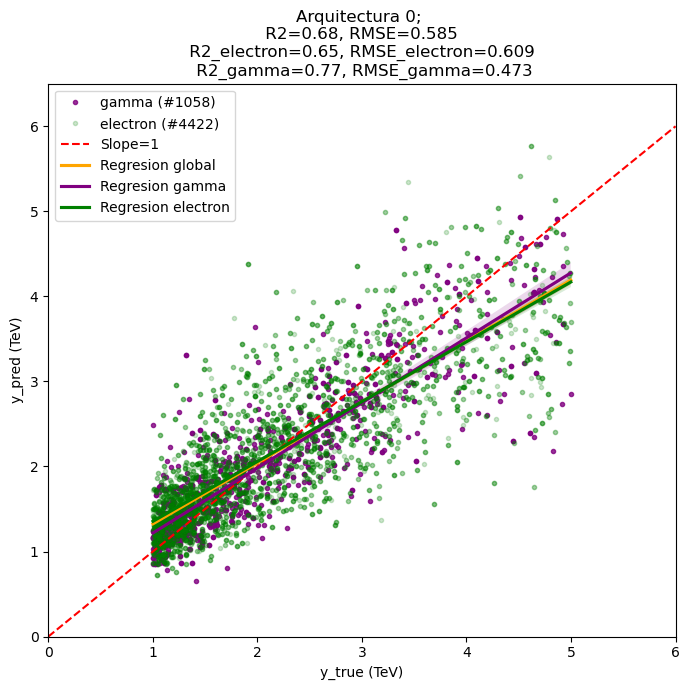

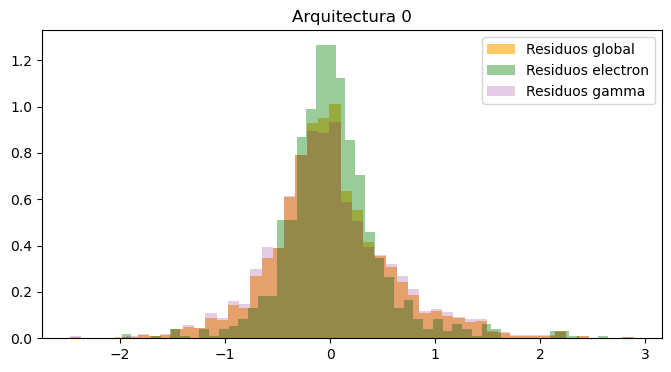

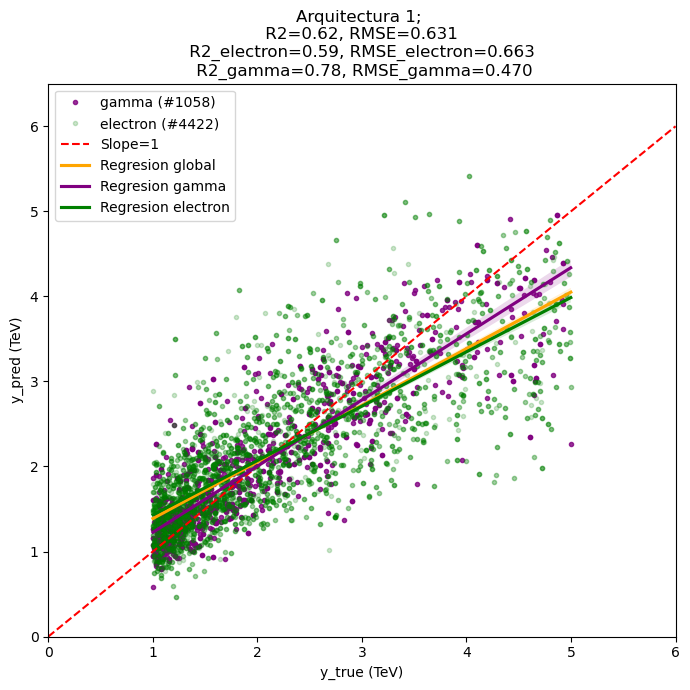

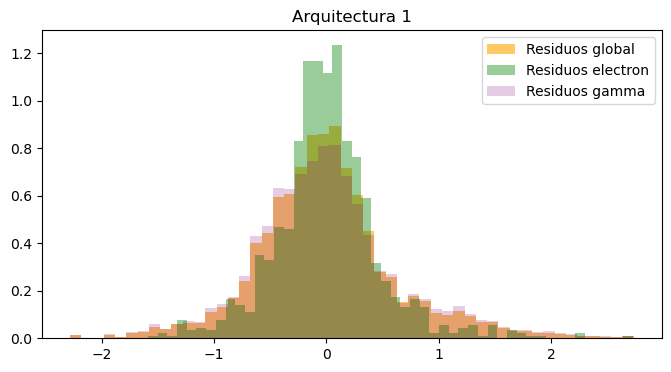

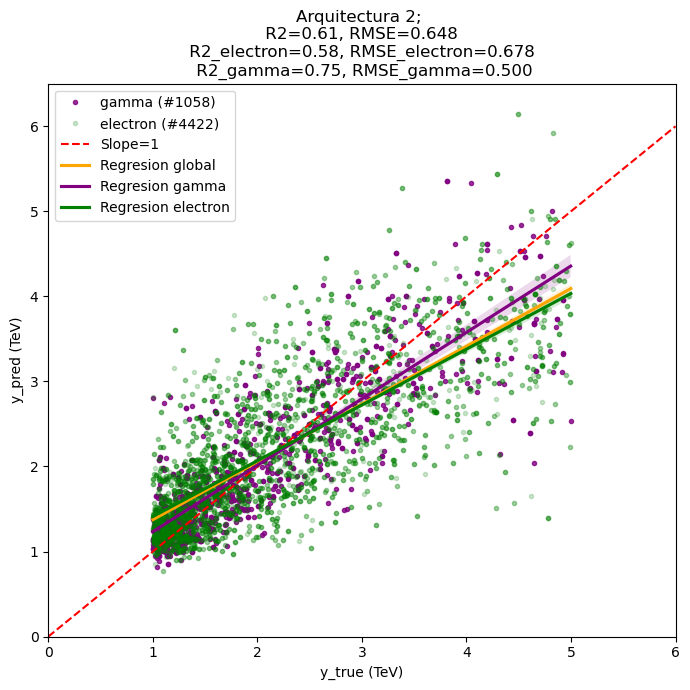

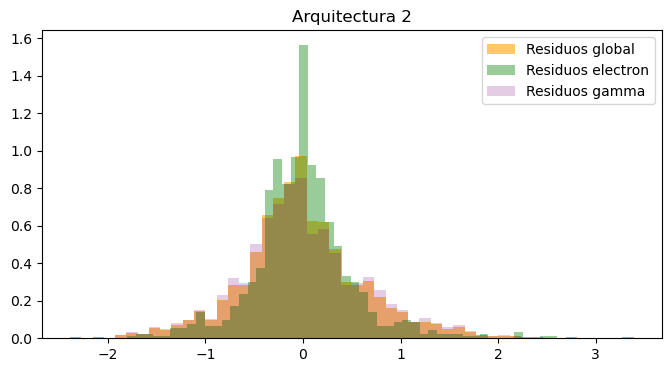

In [ ]:
y_train_list_electron=y_train_list[element_shapes[0]:]
y_train_list_gamma=y_train_list[:element_shapes[0]]

for i,y in enumerate(y_pred_all):
    y=y.squeeze()

    y_electron=y[element_shapes[0]:]
    y_gamma=y[:element_shapes[0]]

    x_aux=np.linspace(1,6,50)

    results,model_poly=polyfit(y_train_list,y,1)
    results_electron,model_poly_electron=polyfit(y_train_list_electron,y_electron,1)
    results_gamma,model_poly_gamma=polyfit(y_train_list_gamma,y_gamma,1)
    
    rmse=np.sqrt(np.mean((y-y_train_list)**2))
    rmse_gamma=np.sqrt(np.mean((y_gamma-y_train_list_gamma)**2))
    rmse_electron=np.sqrt(np.mean((y_electron-y_train_list_electron)**2))

    #y_poly_fit=model_poly(x_aux)
    plt.figure(figsize=(7,7))
    ax=plt.gca()
    plt.plot(y_train_list_gamma,y_gamma,".",color="purple",label=f"gamma (#{element_shapes[0]})",alpha=0.8)
    plt.plot(y_train_list_electron,y_electron,".",color="green",label=f"electron (#{element_shapes[1]})",alpha=0.2)

    plt.plot(np.arange(7),"--r",label="Slope=1")
    sns.regplot(data=pd.DataFrame({"X":y_train_list,"Y":y}),x="X",y="Y",ax=ax,line_kws={'color': 'orange'},label="Regresion global",scatter=False)
    sns.regplot(data=pd.DataFrame({"X":y_train_list_gamma,"Y":y_gamma}),x="X",y="Y",ax=ax,line_kws={'color': 'purple'},label="Regresion gamma",scatter=False)
    sns.regplot(data=pd.DataFrame({"X":y_train_list_electron,"Y":y_electron}),x="X",y="Y",ax=ax,line_kws={'color': 'green'},label="Regresion electron",scatter=False)

    plt.xlim(0,6)
    plt.ylim(0,6.5)
    plt.xlabel("y_true (TeV)")
    plt.ylabel("y_pred (TeV)")
    plt.legend()
    plt.title(f"Arquitectura {i}; \n R2={results['determination']:.2f}, RMSE={rmse:.3f} \n R2_electron={results_electron['determination']:.2f}, RMSE_electron={rmse_electron:.3f} \n R2_gamma={results_gamma['determination']:.2f}, RMSE_gamma={rmse_gamma:.3f}")
    plt.tight_layout()
    plt.savefig(f"../results/007_correlation_energy_filter_{i}_v2.png")
    #plot de la distribucion de errores
    plt.figure(figsize=(8,4))
    res=y_train_list-y
    res_gamma=y_train_list_electron-y_electron
    res_electron=y_train_list_gamma-y_gamma
    plt.hist(res,bins=70,label="Residuos global",density=True,color="orange",alpha=0.7)
    plt.hist(res_electron,bins=70,label="Residuos electron",density=True,color="green",alpha=0.4)
    plt.hist(res_gamma,bins=70,label="Residuos gamma",density=True,color="purple",alpha=0.3)
    plt.legend()
    plt.title(f"Arquitectura {i}")# ; std: {np.std(y_train_list-y)}")
    plt.savefig(f"../results/007_resid_hist_energy_filter_{i}_v2.png")

## Analisis extra sobre los modelos "no especializados en altas energias"

In [ ]:
#cargamos el ultimo modelo de los dos filtros:
modelos_full_range=[tf.keras.models.load_model(name) for name in glob("../modelos/005_modelo_filtro_*_en_boostrap_stage_5_energy.h5")]


In [ ]:
y_pred_all_full_range=[]
total_len=x_train_list[1].shape[0]
n=400
cicles=int(np.ceil(total_len/n))
for i in range(cicles):
    print("Ciclo",i)
    if (n*i+n)>=total_len:
        final=total_len
    else:
        final=n*i+n

    x_aux=[ x[(n*i):final,:,:,:] for x in x_train_list]
    print("Shape",x_aux[0].shape)
    y_pred=[model(x_aux).numpy() for model in modelos_full_range]
    if i==0:
        y_pred_all=y_pred
    else:
        for j in range(len(y_pred_all_full_range)):
            y_pred_all_full_range[j]=np.concatenate([y_pred_all_full_range[j],y_pred[j]],axis=0)

In [ ]:
#y_train_list_electron=y_train_list[element_shapes[0]:]
#y_train_list_gamma=y_train_list[:element_shapes[0]]

for i,y in enumerate(y_pred_all_full_range):
    y=y.squeeze()

    y_electron=y[element_shapes[0]:]
    y_gamma=y[:element_shapes[0]]

    x_aux=np.linspace(1,6,50)

    results,model_poly=polyfit(y_train_list,y,1)
    results_electron,model_poly_electron=polyfit(y_train_list_electron,y_electron,1)
    results_gamma,model_poly_gamma=polyfit(y_train_list_gamma,y_gamma,1)
    
    rmse=np.sqrt(np.mean((y-y_train_list)**2))
    rmse_gamma=np.sqrt(np.mean((y_gamma-y_train_list_gamma)**2))
    rmse_electron=np.sqrt(np.mean((y_electron-y_train_list_electron)**2))

    #y_poly_fit=model_poly(x_aux)
    plt.figure(figsize=(7,7))
    ax=plt.gca()
    plt.plot(y_train_list_gamma,y_gamma,".",color="purple",label=f"gamma (#{element_shapes[0]})",alpha=0.8)
    plt.plot(y_train_list_electron,y_electron,".",color="green",label=f"electron (#{element_shapes[1]})",alpha=0.2)

    plt.plot(np.arange(7),"--r",label="Slope=1")
    sns.regplot(data=pd.DataFrame({"X":y_train_list,"Y":y}),x="X",y="Y",ax=ax,line_kws={'color': 'orange'},label="Regresion global",scatter=False)
    sns.regplot(data=pd.DataFrame({"X":y_train_list_gamma,"Y":y_gamma}),x="X",y="Y",ax=ax,line_kws={'color': 'purple'},label="Regresion gamma",scatter=False)
    sns.regplot(data=pd.DataFrame({"X":y_train_list_electron,"Y":y_electron}),x="X",y="Y",ax=ax,line_kws={'color': 'green'},label="Regresion electron",scatter=False)

    plt.xlim(0,6)
    plt.ylim(0,6.5)
    plt.xlabel("y_true (TeV)")
    plt.ylabel("y_pred (TeV)")
    plt.legend()
    plt.title(f"Arquitectura {i} (modelos full range); \n R2={results['determination']:.2f}, RMSE={rmse:.3f} \n R2_electron={results_electron['determination']:.2f}, RMSE_electron={rmse_electron:.3f} \n R2_gamma={results_gamma['determination']:.2f}, RMSE_gamma={rmse_gamma:.3f}")
    plt.tight_layout()
    plt.savefig(f"../results/005_correlation_energy_filter_{i}_grater_1TeV.png")
    #plot de la distribucion de errores
    plt.figure(figsize=(8,4))
    res=y_train_list-y
    res_gamma=y_train_list_electron-y_electron
    res_electron=y_train_list_gamma-y_gamma
    plt.hist(res,bins=70,label="Residuos global",density=True,color="orange",alpha=0.7)
    plt.hist(res_electron,bins=70,label="Residuos electron",density=True,color="green",alpha=0.4)
    plt.hist(res_gamma,bins=70,label="Residuos gamma",density=True,color="purple",alpha=0.3)
    plt.legend()
    plt.title(f"Arquitectura {i} (modelos full range)")# ; std: {np.std(y_train_list-y)}")
    plt.savefig(f"../results/005_resid_hist_energy_filter_{i}_grater_1TeV.png")